Hunter Bennett | Glass Lab | Kupffer Strains Project | 14 March 2023

Notebook for cis trans analysis of F1 hybrid ATAC-seq data

### Import packages, set plotting parameters

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

Set working directory

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure5_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Define custom functions

In [3]:
def import_homer_diffpeak(depath, appath):
    '''This function takes in a getDiffExpression file created from raw tag counts
       and a peak tag file created with annotatePeaks
       and processes the files so that they contain the same set of genes and can be
       used for data visualization and analysis
       Accepts:
           depath (str): path to getDiffExpression file
           appath (str): path to annotatePeaks file
       Returns:
           de (pandas.DataFrame): modified getDiffExpression file
           ge (pandas.DataFrame): modified annotatePeaks,
           ge_mat (pandas.DataFrame): annotatePeaks file without annotation
           ge_mat_quatn (pandas.DataFrame) : annotatePeaks file without annotation
           and quantile normalized
       '''
    # import packages
    import pandas as pd
    import numpy as np

    # set autosomes for filtering
    autosomes = ['chr1', 'chr2', 'chr3', 'chr4',
                 'chr5', 'chr6', 'chr7', 'chr8',
                 'chr9', 'chr10', 'chr11', 'chr12',
                 'chr13', 'chr14', 'chr15', 'chr16',
                 'chr17', 'chr18', 'chr19']

    # import differential gene expression
    de = pd.read_csv(depath, sep='\t', index_col=0)
    de.index.rename('PeakID', inplace=True)
    de = de.loc[de.Chr.str.contains('|'.join(autosomes)), :]


    # import ge file
    ap = pd.read_csv(appath, sep='\t', index_col=0)
    ap.index.rename('PeakID', inplace=True)

    # select ge transcripts that are in diff_gene
    print('annotatePeaks all peaks', ap.shape)
    print('getDiffExpression selected transcripts', de.shape)
    ap = ap.loc[de.index.tolist(), :]
    print('annotatePeaks selected peaks', ap.shape)


    # return files
    return (de, ap, ap.iloc[:, 18:]) # also return count matrix without annotation

def pull_comparisons_get_diff(diff_gene, seq_type='Repeat'):
    '''This function pulls out comparisons from a diff gene file with multiple comparision groups
    and returns a dict of pandas DataFrames with one comparison each.

    Accepts:
        diff_gene (pandas.DataFrame): diff gene file processed to have
        genes as index and column of RefSeqIDs titled RepeatID
        seq_type (str): Repeat|Peak type of annotation file. repeat for RNA
        peak for ChIP/ATAC

    Returns:
    comp_dict (dict): dictionary of 1 pandas Data Frame per each comparison
    ''' 


    # import packages
    import pandas as pd
    import re
    
    if seq_type=='Repeat':
        # extract groups
        def subset_get_diff(diff_gene, comp):
            return diff_gene.loc[:, [seq_type+'ID',
                                     comp + ' Log2 Fold Change',
                                     comp + ' p-value',
                                     comp + ' adj. p-value']]

    if seq_type=='Peak':
        # exract groups
        def subset_get_diff(diff_gene, comp):
             return diff_gene.loc[:, ['Chr', 'Start', 'End',
                                      'Annotation',
                                      'Gene Name',
                                      'Distance to TSS',
                                       comp + ' Log2 Fold Change',
                                       comp + ' p-value',
                                       comp + ' adj. p-value']]
    
    comp_dict = {}
    pattern='(\w* vs. \w*).*'
    for col in diff_gene.columns.values:
        m = re.search(string=col, pattern=pattern)
        if m:
            df = subset_get_diff(diff_gene, m.group(1))
            if seq_type=='Repeat':
                df.columns = ['RepeatID', 'log2fc', 'pval', 'adj_pval']
            if seq_type=='Peak':
                df['location'] = df.Chr.astype(str)+':'+df.Start.astype(str)+'-'+df.End.astype(str)
                df.columns = ['Chr', 'Start', 'End',
                              'Annotation', 'gene', 'TSS_dist',
                              'log2fc', 'pval', 'adj_pval', 'location']
    
            comp_dict[re.sub('G0[0-9]_', '', m.group(1))] = df
    
    return comp_dict

In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

Import data  
For this analysis we need differential peaks and annotated peak data for a merged set of f1 and f0 atac-seq peaks.

In [5]:
files = [
    'https://zenodo.org/record/7829622/files/f1f0_merged_atac_peaks_f0_raw.txt',
    'https://zenodo.org/record/7829622/files/f1f0_merged_atac_peaks_f1_raw.txt',
    'https://zenodo.org/record/7829622/files/f1f0_merged_diff_output_atac_f0.txt',
    'https://zenodo.org/record/7829622/files/f1f0_merged_diff_output_atac_f1.txt',
]

for f in files:
    df = pd.read_csv(f, sep='\t', index_col=0)
    df.to_csv('./'+f.split('/')[-1], sep='\t')

Read in f0 parental differential peak analysis

In [6]:
diff_peak_f0, peaks_f0, peak_mat_f0 = import_homer_diffpeak(
    './f1f0_merged_diff_output_atac_f0.txt',
    './f1f0_merged_atac_peaks_f0_raw.txt')

comp_dict = pull_comparisons_get_diff(diff_peak_f0, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (71183, 26)
getDiffExpression selected transcripts (71183, 29)
annotatePeaks selected peaks (71183, 26)


dict_keys(['balbcj_atac vs. c57bl6j_atac'])

Read in f1 hybrid differential peak analysis

In [7]:
diff_peak_f1, peaks_f1, peak_mat_f1 = import_homer_diffpeak(
    './f1f0_merged_diff_output_atac_f1.txt',
    './f1f0_merged_atac_peaks_f1_raw.txt')

comp_dict = pull_comparisons_get_diff(diff_peak_f1, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (137971, 26)
getDiffExpression selected transcripts (137971, 29)
annotatePeaks selected peaks (137971, 26)


dict_keys(['00_cb6f1_c57 vs. 01_cb6f1_balb'])

Merge differential peak analysis

In [8]:
# save dict to convert columns to integers
convert_dict = {'Start':int,
                'End':int}

df = diff_peak_f0.merge(diff_peak_f1,
                             suffixes=['', '_f1'],
                             left_index=True,
                             right_index=True,
                             how='outer')

# drop columns without results in both the f1 and f0
df = df.dropna(how='any')
print(df.shape)
df.iloc[:, :5].astype(convert_dict).to_csv('./f1f0_merged_diff_output_atac_f1_f0.txt',
                      sep='\t')

# distal version for motif calling
df_distal = df.reindex(df.index[np.abs(df['Distance to TSS']) > 3000])
print(df_distal.shape)
df_distal.iloc[:, :5].astype(convert_dict).to_csv('./f1f0_merged_diff_output_atac_f1_f0_distal.txt',
                             sep='\t')

(15419, 58)
(10311, 58)


# Cis/trans analysis
For this analysis we define cis regulated transcripts as those that are differentially expressed in a strain specific manner in both the F1 hybrid and the F0 parental strains at a particular p-value and fold change threshold.

we define trans regulated transcripts as those that are differentially expressed in a strain specific manner in the F0 parental strain but not the F1 hybrid at a particular p-value and fold change threshold.

we define mixed regulated transcripts as those that are differentially expressed in a strain specific manner in the F1 hybrid strain but not the F0 parental strain at a particular p-value and fold change threshold.

This approach gives us greater confidence in our estimate of biased allelic expression of a particular transcript, as there is some variance in the relative average expression.

Read in F0 parental differential gene expression

In [9]:
fc = np.log2(2)
padj = 0.05

Note that the order is switched in these, so in fc sign is different:
* F0: C57BL6J biased are > 0
* F1: C57BL6J biased are < 0

In [10]:
f0_log2fc_col = 'balbcj_atac vs. c57bl6j_atac Log2 Fold Change'
f0_padj_col = 'balbcj_atac vs. c57bl6j_atac adj. p-value'

f1_log2fc_col = '00_cb6f1_c57 vs. 01_cb6f1_balb Log2 Fold Change'
f1_padj_col = '00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value'

# flip sign of f1 for cis.
sig_f0 = (df[f0_padj_col] < 0.05)
sig_f1 = (df[f1_padj_col] < 0.05)
sig_both = (sig_f1 & sig_f0)

# same: not sig different and FC < 1
same_f0 = (np.abs(df.loc[:,f0_log2fc_col]) < 1) & (~sig_f0)
same_f1 = (np.abs(df.loc[:,f1_log2fc_col]) < 1) & (~sig_f1)
same_both = (same_f0) & (same_f1)

# cis: difference of f0 and f1 is less than 1 log2fc, also require that at least one has a log2fc > 1
cis = ((np.abs(df.loc[:,f0_log2fc_col] - (-df.loc[:,f1_log2fc_col])) < 1) & ((np.abs(df.loc[:,f0_log2fc_col]) > 1) & sig_both) )

# trans: not cis, abs(f0 log2fc) > 1, abs(f1 log2fc) < 1
trans = ((~cis) & ((np.abs(df.loc[:,f0_log2fc_col])>1) & ((np.abs(df.loc[:,f1_log2fc_col]) < 1))) & sig_f0 )

# mixed: not cis or trans, abs(f0 log2fc) < 1, abs(f1 log2fc) > 1
mixed = ( (~cis) & ((~trans) & ((np.abs(df.loc[:,f0_log2fc_col]) < 1) & (np.abs(df.loc[:,f1_log2fc_col]) > 1))) & sig_f1 )

### Make cis/trans log plot
Set parameters

In [11]:
lists = [cis, trans, mixed]


labels = ['cis', 'trans', 'mixed']
cmap = matplotlib.cm.get_cmap('rocket')
colors = [cmap(0.6), cmap(0.4), cmap(0.2)]

n_cis = cis.sum()
n_trans = trans.sum()
n_mixed = mixed.sum()
n_same = df.shape[0] - (n_cis + n_trans + n_mixed)

legend_elements = [Line2D([0], [0],
                          marker='o', color='w',
                          label='Same: %i' % n_same,
                          markerfacecolor=cmap(0.99),
                          markersize=5),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Cis: %i' % n_cis,
                          markerfacecolor=cmap(0.6),
                          markersize=5),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Trans: %i' % n_trans,
                          markerfacecolor=cmap(0.4),
                          markersize=5),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Mixed: %i' % n_mixed,
                          markerfacecolor=cmap(0.2),
                          markersize=5)]

Make actual plot

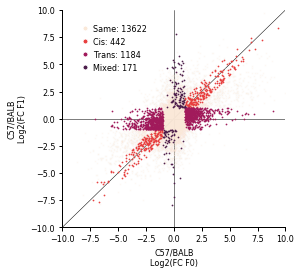

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.loc[:, f0_log2fc_col],
          -df.loc[:, f1_log2fc_col],
           s=0.5,
           c=[cmap(0.99)],
           alpha = 0.2,
           rasterized=True,
           zorder=2)

for peaklist, color in zip(lists, colors):
    ax.scatter(df.loc[peaklist, f0_log2fc_col],
               -df.loc[peaklist, f1_log2fc_col],
               s=0.5,
               c=[color],
               rasterized=True,
               zorder=3)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('C57/BALB\nLog2(FC F0)')
ax.set_ylabel('C57/BALB\nLog2(FC F1)')

ax.legend(handles=legend_elements,
          fontsize=8,
          frameon=False, ncol=1, loc=(0.05,0.7),
          handletextpad=0.05, columnspacing=0.05)

ax.set_xlim([-10,10]);
ax.set_ylim([-10,10]);

### Save peak sets for motif analysis

In [13]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

In [14]:
# cis
cis_balb = (cis) & (df[f0_log2fc_col] < -fc)
cis_c57 = (cis) & (df[f0_log2fc_col] > fc)

# trans
trans_balb = (trans) & (df[f0_log2fc_col] < -fc)
trans_c57 = (trans) & (df[f0_log2fc_col] > fc)

# flipped sign for f1
mixed_balb = (mixed) & (df[f1_log2fc_col] > fc)
mixed_c57 = (mixed) & (df[f1_log2fc_col] < -fc)

In [15]:
lists = [cis_balb, cis_c57, trans_balb, trans_c57, mixed_balb, mixed_c57, same_f0, same_f1, same_both]
labels = ['cis_balb_hunterFCThenPadj', 'cis_c57_hunterFCThenPadj',
          'trans_balb_hunterFCThenPadj', 'trans_c57_hunterFCThenPadj',
          'mixed_balb_hunterFCThenPadj', 'mixed_c57_hunterFCThenPadj',
          'same_f0_hunterFCThenPadj', 'same_f1_hunterFCThenPadj',
          'same_f0f1_hunterFCThenPadj']

In [16]:
for label, peaklist in zip(labels, lists):
    df.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/atac_'+label+'.txt',
        sep='\t')
    df_distal.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/atac_'+label+'_distal.txt',
        sep='\t')